In [1]:
# The code was removed by Watson Studio for sharing.

<h1 style="">Use <code>scikit</code> to train and store a reference model with ibm-watsonx-ai</h1>

## This notebook contains steps and code to demonstrate support of AI Lifecycle features in watsonx.ai Runtime service. It contains steps and code to work with ibm-watsonx-ai and ibm-watson-pipelines library available in PyPI repository. It also introduces commands for getting model and training data, persisting model, deploying model, scoring it, updating the model and redeploying it.

Some familiarity with Python is helpful. This notebook uses **Python 3.11** with the <a href="https://pypi.org/project/ibm-watsonx-ai/" target="_blank" rel="noopener no referrer"><code>ibm-watsonx-ai</code></a> and <a href="https://pypi.org/project/ibm-watson-pipelines/" target="_blank" rel="noopener no referrer"><code>ibm-watson-pipelines</code></a> package.

### Contents

- [Setup](#setup)
- [Model building](#model)
- [Storing notebook results](#results)

<a></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

- If you don't see a project token inserted in the first cell of this notebook, then click the **More** menu, and choose **Insert project token**.

-  Create a <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/getting-started/wml-plans.html?context=wx&amp;audience=wdp" target="_blank" rel="noopener no referrer">here</a>).

### Connection to watsonx.ai

Authenticate the watsonx.ai service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use <a href="https://cloud.ibm.com/docs/cli/index.html" target="_blank" rel="noopener no referrer">IBM Cloud CLI</a> to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.

Location of your watsonx.ai Runtime instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the <a href="https://cloud.ibm.com/iam#/users" target="_blank" rel="noopener no referrer"><strong>Users</strong> section of the Cloud console</a>. From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the <a href="https://cloud.ibm.com/apidocs/machine-learning" target="_blank" rel="noopener no referrer"><strong>Endpoint URLs</strong> section of the watsonx.ai Runtime docs</a>. You can check your instance location in your  <a href="https://cloud.ibm.com/catalog/services/watsonxai-runtime" target="_blank" rel="noopener no referrer">watsonx.ai Runtime Service</a> instance details.

You can also get service specific apikey by going to the <a href="https://cloud.ibm.com/iam/serviceids" target="_blank" rel="noopener no referrer"><strong>Service IDs</strong> section of the Cloud Console</a>. From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

If you cannot connect to Watson pipelines client check if `cpdaas_url` matches host url you can see for this notebook preceded by `api.`

In [2]:
api_key = '4E_rmMx1oIjUJEUeGCvwwDnVj598DQOj-ivcSF4yJR58'
location = 'us-south'
cpdaas_url = 'https://api.dataplatform.cloud.ibm.com'

## Package installation

In [3]:
!pip install wget | tail -n 1
!pip install -U ibm-watsonx-ai | tail -n 1
!pip install "scikit-learn==1.3.2" | tail -n 1
!pip install -U ibm-watson-pipelines | tail -n 1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-model-optimization-nightly 0.7.4.dev0 requires absl-py~=2.0.0, but you have absl-py 1.4.0 which is incompatible.
tf2onnx 1.15.1 requires protobuf~=4.21.12, but you have protobuf 3.20.3 which is incompatible.
langchain 0.3.4 requires pydantic<3.0.0,>=2.7.4, but you have pydantic 1.10.22 which is incompatible.
langchain-core 0.3.55 requires pydantic<3.0.0,>=2.5.2; python_full_version < "3.12.4", but you have pydantic 1.10.22 which is incompatible.
pydantic-settings 2.6.0 requires pydantic>=2.7.0, but you have pydantic 1.10.22 which is incompatible.
llama-index-core 0.12.32 requires pydantic>=2.8.0, but you have pydantic 1.10.22 which is incompatible.


In [4]:
import os
import numpy as np
import pandas as pd

from ibm_watsonx_ai import Credentials, APIClient
from ibm_watson_pipelines import WatsonPipelines
from ibm_watson_pipelines.cpd_paths import CpdScope, CpdPath

In [5]:
credentials = Credentials(
    api_key=api_key,
    url='https://' + location + '.ml.cloud.ibm.com'
)

client = APIClient(credentials)

## Notebook parameters

This notebook is run from the Orchestration Pipeline that passes following environment variables:

- `training_data_asset` - the training data set (as CPD Path, e.g. 'cpd:///spaces/b5ad9f7e-eec3-49ad-a8f6-86354ff29134/assets/81d9c711-5bc3-4017-ab07-d467ebfa3215')
- `model_name` - the reference model name

In [6]:
TRAINING_DATA_ASSET_CPD_PATH = os.getenv('training_data_asset')
MODEL_NAME = os.getenv('model_name', 'reference_model')

## Connect to Watsonx.ai Runtime

Select the space, where the training data asset is located.

In [7]:
pipelines_client = WatsonPipelines.from_apikey(api_key, url=cpdaas_url)

# Extract space ID from CPD Path passed from the Watson Pipeline as an environment variable
space_scope = CpdPath.from_string(TRAINING_DATA_ASSET_CPD_PATH)
space_id = space_scope.scope_id()


TypeError: Path expected to be a string, but is of type NoneType

In [44]:

client.set.default_space(space_id)

'SUCCESS'

## Download the training data asset

Download the training data asset pointed in the `TRAINING_DATA_ASSET_CPD_PATH` environment variable passed from the Watson Pipeline.

In [45]:
DATA_FILE_NAME='training_data.csv'

asset_cpd_path = CpdPath.from_string(TRAINING_DATA_ASSET_CPD_PATH)
asset_id = asset_cpd_path.resource_id()
client.data_assets.download(asset_uid=asset_id, filename=DATA_FILE_NAME)

data_df = pd.read_csv(DATA_FILE_NAME)

Successfully saved data asset content to file: 'training_data.csv'


# Model building and deployment <a></a>

In this section you will learn how to train Scikit-learn model and next deploy it as web-service using Watsonx.ai Runtime service.

## Explore data

In [46]:
data_df.head()

,CheckingStatus,LoanDuration,CreditHistory,LoanPurpose,LoanAmount,ExistingSavings,EmploymentDuration,InstallmentPercent,Sex,OthersOnLoan,...,OwnsProperty,Age,InstallmentPlans,Housing,ExistingCreditsCount,Job,Dependents,Telephone,ForeignWorker,Risk
0,0_to_200,31,credits_paid_to_date,other,1889,100_to_500,less_1,3,female,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
1,less_0,18,credits_paid_to_date,car_new,462,less_100,1_to_4,2,female,none,...,savings_insurance,37,stores,own,2,skilled,1,none,yes,No Risk
2,less_0,15,prior_payments_delayed,furniture,250,less_100,1_to_4,2,male,none,...,real_estate,28,none,own,2,skilled,1,yes,no,No Risk
3,0_to_200,28,credits_paid_to_date,retraining,3693,less_100,greater_7,3,male,none,...,savings_insurance,32,none,own,1,skilled,1,none,yes,No Risk
4,no_checking,28,prior_payments_delayed,education,6235,500_to_1000,greater_7,3,male,none,...,unknown,57,none,own,2,skilled,1,none,yes,Risk


In [47]:
print('Columns: ', list(data_df.columns))
print('Number of columns: ', len(data_df.columns))

Columns:  ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'Risk']
Number of columns:  21


As you can see, the data contains twenty one fields. `Risk` field is the one you would like to predict using feedback data.

In [48]:
print('Number of records: ', data_df.Risk.count())

Number of records:  5000


In [49]:
target_count = data_df.groupby('Risk')['Risk'].count()
target_count

Risk
No Risk    3330
Risk       1670
Name: Risk, dtype: int64

## Visualize data

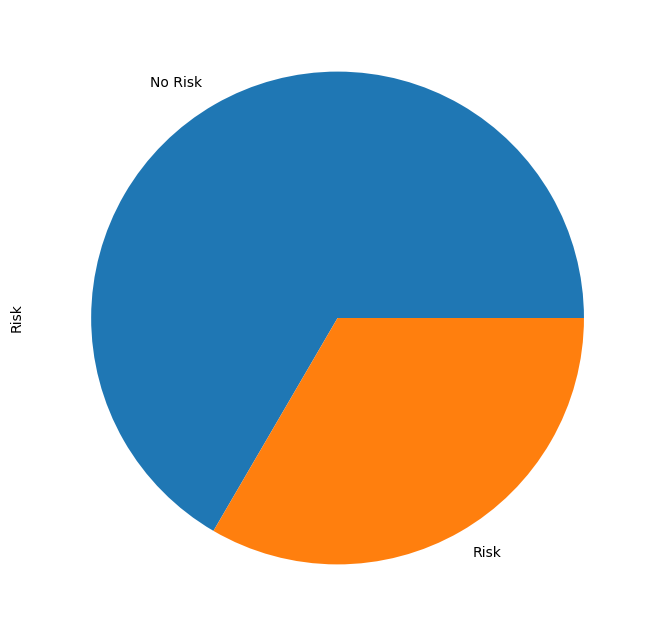

In [50]:
target_count.plot.pie(figsize=(8, 8));

## Create a model
In this section you will learn how to:

- Prepare data for training a model
- Create machine learning pipeline
- Train a model

### You will start with importing required libraries

In [51]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

### Splitting the data into train and test

In [52]:
train_data, test_data = train_test_split(data_df, test_size=0.2)

### Preparing the machine learning pipeline

In [53]:
features_idx = np.s_[0:-1]
all_records_idx = np.s_[:]
first_record_idx = np.s_[0]

In this step you will encode target column labels into numeric values. You can use `inverse_transform` to decode numeric predictions into labels.

In [54]:
string_fields = [type(fld) is str for fld in train_data.iloc[first_record_idx, features_idx]]
ct = ColumnTransformer([("ohe", OneHotEncoder(), list(np.array(train_data.columns)[features_idx][string_fields]))])
clf_linear = SGDClassifier(loss='log_loss', penalty='l2', max_iter=1000, tol=1e-5)

pipeline_linear = Pipeline([('ct', ct), ('clf_linear', clf_linear)])

### Train a model

In [55]:
risk_model = pipeline_linear.fit(train_data.drop('Risk', axis=1), train_data.Risk)

### Evaluate the model

In [56]:
from sklearn.metrics import roc_auc_score

predictions = risk_model.predict(test_data.drop('Risk', axis=1))
indexed_preds = [0 if prediction=='No Risk' else 1 for prediction in predictions]

real_observations = test_data.Risk.replace('Risk', 1)
real_observations = real_observations.replace('No Risk', 0).values

auc = roc_auc_score(real_observations, indexed_preds)
print(auc)

0.7305941976521695


## Publish the model

In this section, the notebook uses the supplied Watsonx.ai client to save the model (including the machine learning pipeline) to the Watsonx.ai Runtime instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

### Remove existing model

In [57]:
models = client.repository.get_model_details()['resources']
model_id = next((m['metadata']['id'] for m in models if m['metadata']['name'] == MODEL_NAME), None)

model_deployments = client.deployments.get_details()
for deployment in model_deployments['resources']:
    deployment_id = deployment['metadata']['id']
    asset_id = deployment['entity']['asset']['id']
    if asset_id == model_id:
        print('Deleting deployment id', deployment_id)
        client.deployments.delete(deployment_id)

if model_id:
    print('Deleting model id', model_id)
    client.repository.delete(model_id)

client.repository.list_models()

Deleting model id 3ff189e4-d222-4bcf-85bd-4fa844115eb6


,ID,NAME,CREATED,TYPE,SPEC_STATE,SPEC_REPLACEMENT
0,13ff2cd2-6df9-437f-861c-9be00b93d922,on-boarding-credit-risk-prediction-P2_hpo_d_ou...,2024-09-27T12:08:03.393Z,wml-hybrid_0.1,supported,


In [58]:
software_spec_id = client.software_specifications.get_uid_by_name('runtime-24.1-py3.11')

In [59]:
model_props = {
    client.repository.ModelMetaNames.NAME: "{}".format(MODEL_NAME),
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_id,
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.3",
    client.repository.ModelMetaNames.TAGS: ["Pipelines-demo-model"]
}

In [60]:
wml_models = client.repository.get_details()
model_id = None
for model in wml_models['models']['resources']:
    if MODEL_NAME == model['metadata']['name']:
        model_id = model['metadata']['id']
        break

if model_id is None:
    print("Storing model ...")

    published_model_details = client.repository.store_model(model=risk_model, meta_props=model_props, training_data=data_df.drop(['Risk'], axis=1), training_target=data_df.Risk)
    model_id = client.repository.get_model_id(published_model_details)
    print("Done")

Storing model ...
Done


In [61]:
client.repository.list_models()

,ID,NAME,CREATED,TYPE,SPEC_STATE,SPEC_REPLACEMENT
0,85ea84e4-c507-46dd-809b-b44c8d9282a0,reference_model,2025-01-31T11:47:44.767Z,scikit-learn_1.3,supported,
1,13ff2cd2-6df9-437f-861c-9be00b93d922,on-boarding-credit-risk-prediction-P2_hpo_d_ou...,2024-09-27T12:08:03.393Z,wml-hybrid_0.1,supported,


Prepare the model CPD Path which would be stored as one of the notebook result.

In [62]:
model_path = f"{space_scope.scope()}/assets/{model_id}"
model_path

'cpd:///spaces/f6d3d3ad-48ff-4bb7-9103-46114a17056e/assets/85ea84e4-c507-46dd-809b-b44c8d9282a0'

<a></a>
## Save notebook results

This notebook is run from the Orchestration Pipeline that expects following results:

- `trained_model` - the trained model (stored in Watsonx.ai Runtime) CPD Path
- `evaluation_result` - the evaluation (ROC AUC) result

In [63]:
results = {
  "trained_model": model_path,
  "evaluation_result": auc
}
print(results)

{'trained_model': 'cpd:///spaces/f6d3d3ad-48ff-4bb7-9103-46114a17056e/assets/85ea84e4-c507-46dd-809b-b44c8d9282a0', 'evaluation_result': 0.7305941976521695}


Finally, store the results, which are consumed by a flow downstream nodes, using the Watson Pipelines client.

In [64]:
res = pipelines_client.store_results(results)

print('DONE')

Running outside of Watson Pipelines - storing results in the local filesystem for testing purposes...

  output paths:
    - "trained_model": .ibm_watson_pipelines/results/trained_model
    - "evaluation_result": .ibm_watson_pipelines/results/evaluation_result
DONE


### Authors

**Rafał Bigaj**, System Architect with long successful record of building and leading teams. Broad and practical knowledge in the area of cloud computing, machine learning and distributed systems development.

**Krzysztof Niedziela**, Automation Developer in Cloud Pack for Data.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.